Directory weather_data has been deleted.
Directory weather_data has been deleted.


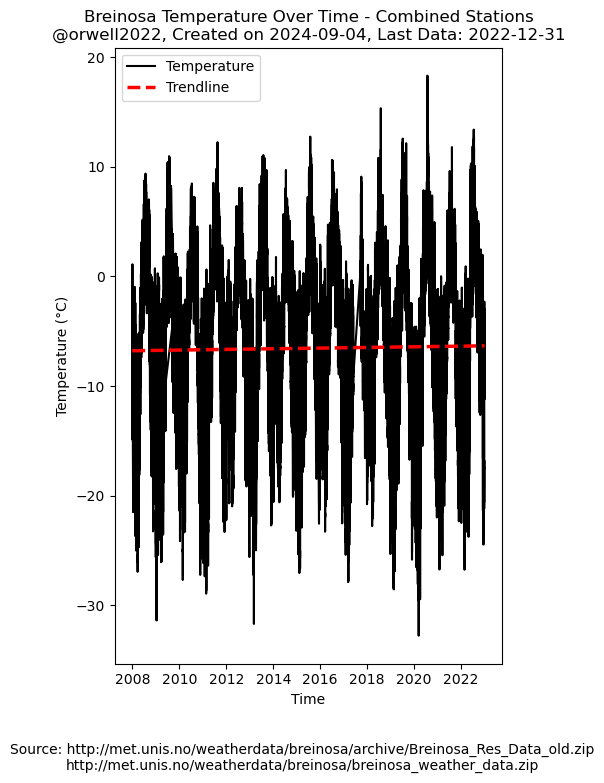

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io, shutil

# Delete the download directory
def clean_up(directory):
    """
    Deletes the specified directory and all its contents.
    """
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Directory {directory} has been deleted.")

def download_and_extract(url, extract_to="weather_data"):
    """
    Downloads and extracts a ZIP file from the given URL.
    """
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_to)
    return extract_to

def find_dat_file(directory):
    """
    Finds the first .dat file in the given directory.
    """
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".dat"):
                return os.path.join(root, file)
    raise FileNotFoundError("No .dat file found in the directory.")

def load_and_prepare_data(url):
    """
    Downloads, extracts, finds, and loads the data from the given URL.
    Adjusts columns to a standard format.
    """
    # Step 1: Download and unzip the data
    clean_up("weather_data")  # Clean up previous data if it exists
    data_directory = download_and_extract(url)

    # Find the .dat file in the extracted directory
    dat_file_path = find_dat_file(data_directory)

    # Step 2: Load the data with correct column names
    if "boheman" in dat_file_path.lower():
        # Manually specify the columns for Bohemanneset
        column_names = ['TIMESTAMP', 'RECORD', 'ID', 'AirTC_Avg', 'AirTC_Min', 'AirTC_Max', 
                        'RH_Avg', 'RH_Max', 'Pressure', 'WS_ms_Avg', 'WS_ms_Min', 'WS_ms_Max', 
                        'WindDir', 'Extra_1', 'Batt_Volt_Min']
        data = pd.read_csv(dat_file_path, delimiter=',', skiprows=1, names=column_names, low_memory=False)
    elif "breinosa" in dat_file_path.lower():
        # Manually specify the columns for Breinosa
        column_names = ['TIMESTAMP', 'RECORD', 'ID', 'AirTC_Avg', 'AirTC_Min', 'AirTC_Max', 
                        'RH_Avg', 'RH_Max', 'WS_ms_Avg', 'WindDir', 'WS_ms_Max', 
                        'BP_mBar', 'Batt_Volt_Min']
        data = pd.read_csv(dat_file_path, delimiter=',', skiprows=1, names=column_names, low_memory=False)
    else:
        raise ValueError("Unrecognized dataset structure.")

    # Step 3: Ensure the TIMESTAMP column is in datetime format with explicit parsing
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Drop rows where the TIMESTAMP could not be parsed
    data = data.dropna(subset=['TIMESTAMP'])

    # Convert the temperature column to numeric, coercing errors
    data['AirTC_Avg'] = pd.to_numeric(data['AirTC_Avg'], errors='coerce')

    # Drop rows where the temperature could not be parsed
    data = data.dropna(subset=['AirTC_Avg'])

    # Create additional columns for year, month, and day
    data['Year'] = data['TIMESTAMP'].dt.year
    data['Month'] = data['TIMESTAMP'].dt.month
    data['Day'] = data['TIMESTAMP'].dt.day

    return data, 'AirTC_Avg'

# URLs for the datasets
urls = [
    "http://met.unis.no/weatherdata/breinosa/archive/Breinosa_Res_Data_old.zip",
    "http://met.unis.no/weatherdata/breinosa/breinosa_weather_data.zip"
]

# Load and merge the datasets
data_combined = pd.DataFrame()

for url in urls:
    data, temp_col = load_and_prepare_data(url)
    # Standardize the temperature column name to 'Temperature' for consistency
    data = data.rename(columns={temp_col: 'Temperature'})
    data_combined = pd.concat([data_combined, data], ignore_index=True)

# Remove all 2024 data
data_combined = data_combined[data_combined['Year'] != 2024]
data_combined = data_combined[data_combined['Year'] != 2023]

# Find the last available date
last_date = data_combined['TIMESTAMP'].max()

# Find the earliest year available and the corresponding first date with the same month/day as last_date
first_year_data = data_combined[data_combined['Year'] == data_combined['Year'].min()]

try:
    first_date = first_year_data[
        (first_year_data['Month'] == last_date.month) &
        (first_year_data['Day'] == last_date.day)
    ]['TIMESTAMP'].iloc[0]
except IndexError:
    # If the exact month/day is not available, just use the earliest available date in the first year
    first_date = first_year_data['TIMESTAMP'].min()

# Filter the data to match this date range
filtered_data = data_combined[(data_combined['TIMESTAMP'] >= first_date) & (data_combined['TIMESTAMP'] <= last_date)]

# Step 4: Generate the overall trend plot

plt.figure(figsize=(5, 8))
plt.plot(filtered_data['TIMESTAMP'], filtered_data['Temperature'], label='Temperature', color='black')

# Calculate and plot the trendline for overall data
z_overall = np.polyfit(pd.to_numeric(filtered_data['TIMESTAMP']), filtered_data['Temperature'], 1)
p_overall = np.poly1d(z_overall)
plt.plot(filtered_data['TIMESTAMP'], p_overall(pd.to_numeric(filtered_data['TIMESTAMP'])), "r--", linewidth=2.5, label='Trendline')

# Adding labels and title
creation_date = pd.Timestamp.today().strftime('%Y-%m-%d')
last_data_day = filtered_data['TIMESTAMP'].max().strftime('%Y-%m-%d')

plt.title(f'Breinosa Temperature Over Time - Combined Stations\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time')

# Adding source as footnote
plt.figtext(0.5, -0.02, 'Source: '+urls[0]+'\n'+urls[1], wrap=True, horizontalalignment='center', fontsize=10)

# Displaying the plot
plt.legend()
plt.show()


Directory weather_data has been deleted.
Directory weather_data has been deleted.


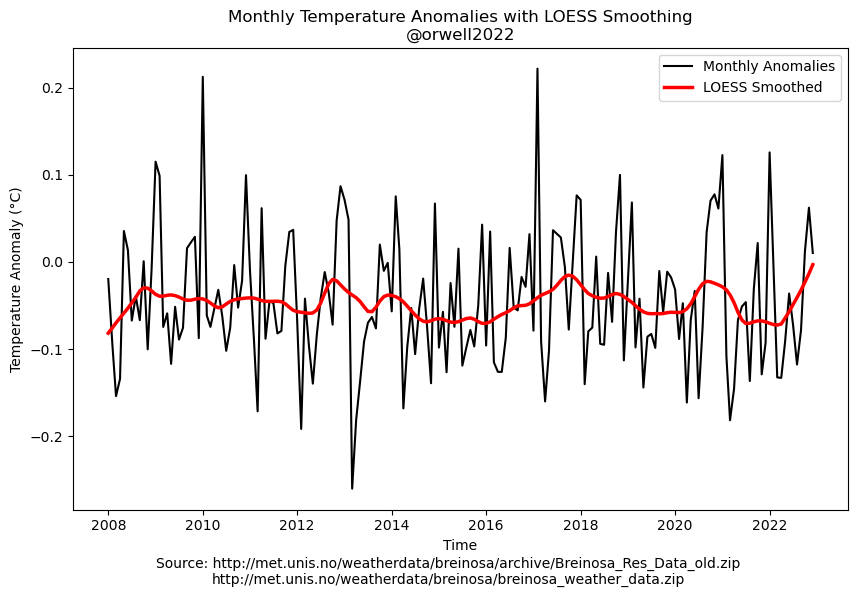

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io, shutil
from scipy.interpolate import interp1d
import statsmodels.api as sm

# Delete the download directory
def clean_up(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Directory {directory} has been deleted.")

def download_and_extract(url, extract_to="weather_data"):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_to)
    return extract_to

def find_dat_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".dat"):
                return os.path.join(root, file)
    raise FileNotFoundError("No .dat file found in the directory.")

def load_and_prepare_data(url):
    clean_up("weather_data")
    data_directory = download_and_extract(url)
    dat_file_path = find_dat_file(data_directory)

    if "boheman" in dat_file_path.lower():
        column_names = ['TIMESTAMP', 'RECORD', 'ID', 'AirTC_Avg', 'AirTC_Min', 'AirTC_Max', 
                        'RH_Avg', 'RH_Max', 'Pressure', 'WS_ms_Avg', 'WS_ms_Min', 'WS_ms_Max', 
                        'WindDir', 'Extra_1', 'Batt_Volt_Min']
        data = pd.read_csv(dat_file_path, delimiter=',', skiprows=1, names=column_names, low_memory=False)
    elif "breinosa" in dat_file_path.lower():
        column_names = ['TIMESTAMP', 'RECORD', 'ID', 'AirTC_Avg', 'AirTC_Min', 'AirTC_Max', 
                        'RH_Avg', 'RH_Max', 'WS_ms_Avg', 'WindDir', 'WS_ms_Max', 
                        'BP_mBar', 'Batt_Volt_Min']
        data = pd.read_csv(dat_file_path, delimiter=',', skiprows=1, names=column_names, low_memory=False)
    else:
        raise ValueError("Unrecognized dataset structure.")

    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    data = data.dropna(subset=['TIMESTAMP'])

    data['AirTC_Avg'] = pd.to_numeric(data['AirTC_Avg'], errors='coerce')
    data = data.dropna(subset=['AirTC_Avg'])

    data['Year'] = data['TIMESTAMP'].dt.year
    data['Month'] = data['TIMESTAMP'].dt.month
    data['Day'] = data['TIMESTAMP'].dt.day
    data['Date'] = data['TIMESTAMP'].dt.date  # Add a Date column for easier grouping

    return data, 'AirTC_Avg'

# URLs for the datasets
urls = [
    "http://met.unis.no/weatherdata/breinosa/archive/Breinosa_Res_Data_old.zip",
    "http://met.unis.no/weatherdata/breinosa/breinosa_weather_data.zip"
]

# Load and merge the datasets
data_combined = pd.DataFrame()

for url in urls:
    data, temp_col = load_and_prepare_data(url)
    data = data.rename(columns={temp_col: 'Temperature'})
    data_combined = pd.concat([data_combined, data], ignore_index=True)

# Remove data after 2023-07-22
data_combined = data_combined[data_combined['TIMESTAMP'] <= '2023-07-22']

# Identify the first and last years in the dataset
first_year = data_combined['Year'].min()
last_year = data_combined['Year'].max()

# Filter out the first and last years to get only complete years
full_years_data = data_combined[(data_combined['Year'] > first_year) & (data_combined['Year'] < last_year)]

# Calculate daily medians using only full years
daily_medians = full_years_data.groupby('Date')['Temperature'].median().reset_index()

# Ensure we have a full year for interpolation by filling in missing dates
date_range = pd.date_range(start=daily_medians['Date'].min(), end=daily_medians['Date'].max(), freq='D')
daily_medians = daily_medians.set_index('Date').reindex(date_range).interpolate(method='linear').reset_index()
daily_medians.columns = ['Date', 'Median_Temperature']

# Calculate anomalies for each date
daily_avg = data_combined.groupby('Date')['Temperature'].mean().reset_index()
daily_avg = daily_avg.set_index('Date').reindex(date_range).interpolate(method='linear').reset_index()
daily_avg.columns = ['Date', 'Avg_Temperature']

anomalies = daily_avg.copy()
anomalies['Median_Temperature'] = daily_medians['Median_Temperature']
anomalies['Anomaly'] = anomalies['Avg_Temperature'] - anomalies['Median_Temperature']

# Aggregate to monthly
anomalies['YearMonth'] = anomalies['Date'].dt.to_period('M')
monthly_anomalies = anomalies.groupby('YearMonth')['Anomaly'].mean().reset_index()
monthly_anomalies['YearMonth'] = monthly_anomalies['YearMonth'].dt.to_timestamp()

# Plot with LOESS smoothing
plt.figure(figsize=(10, 6))
plt.plot(monthly_anomalies['YearMonth'], monthly_anomalies['Anomaly'], label='Monthly Anomalies', color='black')

# Apply LOESS smoothing
lowess = sm.nonparametric.lowess
smoothed = lowess(monthly_anomalies['Anomaly'], np.arange(len(monthly_anomalies)), frac=0.1)
plt.plot(monthly_anomalies['YearMonth'], smoothed[:, 1], label='LOESS Smoothed', color='red', linewidth=2.5)

# Adding labels and title
plt.title('Monthly Temperature Anomalies with LOESS Smoothing\n@orwell2022')
plt.ylabel('Temperature Anomaly (°C)')
plt.xlabel('Time')

# Adding source as footnote
plt.figtext(0.5, -0.01, 'Source: '+urls[0]+'\n'+urls[1], wrap=True, horizontalalignment='center', fontsize=10)

# Displaying the plot
plt.legend()
plt.show()


Directory weather_data has been deleted.
Directory weather_data has been deleted.


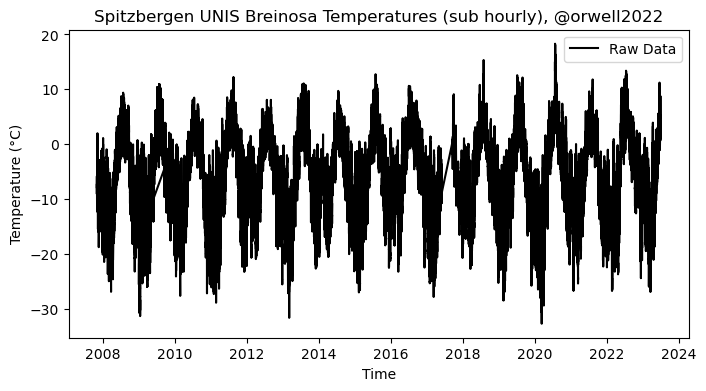

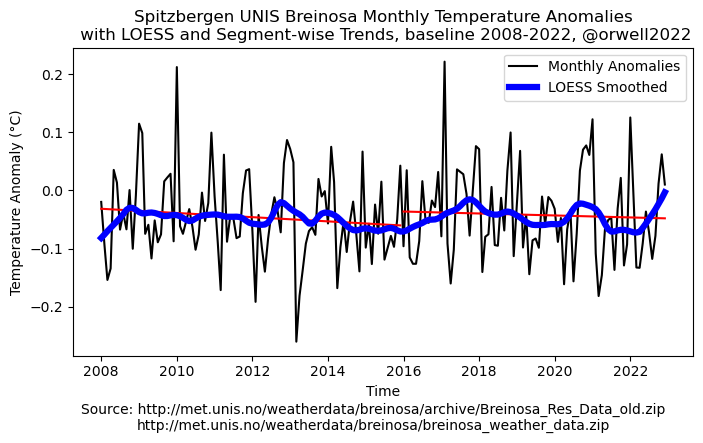

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io, shutil
import statsmodels.api as sm

# Function to delete the download directory
def clean_up(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Directory {directory} has been deleted.")

# Function to download and extract data
def download_and_extract(url, extract_to="weather_data"):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_to)
    return extract_to

# Function to find the .dat file in the extracted directory
def find_dat_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".dat"):
                return os.path.join(root, file)
    raise FileNotFoundError("No .dat file found in the directory.")

# Function to load and prepare data
def load_and_prepare_data(url):
    clean_up("weather_data")
    data_directory = download_and_extract(url)
    dat_file_path = find_dat_file(data_directory)

    # Define column names based on the dataset
    if "boheman" in dat_file_path.lower():
        column_names = [
            'TIMESTAMP', 'RECORD', 'ID', 'AirTC_Avg', 'AirTC_Min', 'AirTC_Max', 
            'RH_Avg', 'RH_Max', 'Pressure', 'WS_ms_Avg', 'WS_ms_Min', 'WS_ms_Max', 
            'WindDir', 'Extra_1', 'Batt_Volt_Min'
        ]
    elif "breinosa" in dat_file_path.lower():
        column_names = [
            'TIMESTAMP', 'RECORD', 'ID', 'AirTC_Avg', 'AirTC_Min', 'AirTC_Max', 
            'RH_Avg', 'RH_Max', 'WS_ms_Avg', 'WindDir', 'WS_ms_Max', 
            'BP_mBar', 'Batt_Volt_Min'
        ]
    else:
        raise ValueError("Unrecognized dataset structure.")

    # Load the data
    data = pd.read_csv(dat_file_path, delimiter=',', skiprows=1, names=column_names, low_memory=False)
    
    # Convert TIMESTAMP to datetime and ensure temperature data is numeric
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    data = data.dropna(subset=['TIMESTAMP'])
    data['AirTC_Avg'] = pd.to_numeric(data['AirTC_Avg'], errors='coerce')
    data = data.dropna(subset=['AirTC_Avg'])

    # Add additional date-related columns
    data['Year'] = data['TIMESTAMP'].dt.year
    data['Month'] = data['TIMESTAMP'].dt.month
    data['Day'] = data['TIMESTAMP'].dt.day
    data['Date'] = data['TIMESTAMP'].dt.date  # Add a Date column for easier grouping

    return data, 'AirTC_Avg'

# URLs for the datasets
urls = [
    "http://met.unis.no/weatherdata/breinosa/archive/Breinosa_Res_Data_old.zip",
    "http://met.unis.no/weatherdata/breinosa/breinosa_weather_data.zip"
]

# Load and merge the datasets
data_combined = pd.DataFrame()
for url in urls:
    data, temp_col = load_and_prepare_data(url)
    data = data.rename(columns={temp_col: 'Temperature'})
    data_combined = pd.concat([data_combined, data], ignore_index=True)

# Remove data after 2023-07-01
data_combined = data_combined[data_combined['TIMESTAMP'] <= '2023-07-01']

# Identify the first and last years in the dataset
first_year = data_combined['Year'].min()
last_year = data_combined['Year'].max()

# Filter out the first and last years to get only complete years
full_years_data = data_combined[(data_combined['Year'] > first_year) & (data_combined['Year'] < last_year)]

# Calculate daily medians using only full years
daily_medians = full_years_data.groupby('Date')['Temperature'].median().reset_index()

# Ensure we have a full year for interpolation by filling in missing dates
date_range = pd.date_range(start=daily_medians['Date'].min(), end=daily_medians['Date'].max(), freq='D')
daily_medians = daily_medians.set_index('Date').reindex(date_range).interpolate(method='linear').reset_index()
daily_medians.columns = ['Date', 'Median_Temperature']

# Calculate anomalies for each date
daily_avg = data_combined.groupby('Date')['Temperature'].mean().reset_index()
daily_avg = daily_avg.set_index('Date').reindex(date_range).interpolate(method='linear').reset_index()
daily_avg.columns = ['Date', 'Avg_Temperature']

anomalies = daily_avg.copy()
anomalies['Median_Temperature'] = daily_medians['Median_Temperature']
anomalies['Anomaly'] = anomalies['Avg_Temperature'] - anomalies['Median_Temperature']

# Aggregate to monthly
anomalies['YearMonth'] = anomalies['Date'].dt.to_period('M')
monthly_anomalies = anomalies.groupby('YearMonth')['Anomaly'].mean().reset_index()
monthly_anomalies['YearMonth'] = monthly_anomalies['YearMonth'].dt.to_timestamp()

# Plot raw data with daily averages
plt.figure(figsize=(8, 4))
plt.plot(data_combined['TIMESTAMP'], data_combined['Temperature'], label='Raw Data', color='black')

# Adding labels and title
plt.title('Spitzbergen UNIS Breinosa Temperatures (sub hourly), @orwell2022')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time')
plt.legend()
plt.show()

# Plot monthly anomalies with LOESS smoothing and segment-wise trends
plt.figure(figsize=(8, 4))
plt.plot(monthly_anomalies['YearMonth'], monthly_anomalies['Anomaly'], label='Monthly Anomalies', color='black')

# Segment-wise linear trends
# Segment 1: Start to end of 2015
segment1 = monthly_anomalies[monthly_anomalies['YearMonth'] <= pd.to_datetime('2015-12-31')]
z1 = np.polyfit(np.arange(len(segment1)), segment1['Anomaly'], 1)
p1 = np.poly1d(z1)
plt.plot(segment1['YearMonth'], p1(np.arange(len(segment1))), "red", linewidth=1.5)

# Segment 2: 2016 to end
segment2 = monthly_anomalies[monthly_anomalies['YearMonth'] >= pd.to_datetime('2016-01-01')]
z2 = np.polyfit(np.arange(len(segment2)), segment2['Anomaly'], 1)
p2 = np.poly1d(z2)
plt.plot(segment2['YearMonth'], p2(np.arange(len(segment2))), "red", linewidth=1.5)

# Apply LOESS smoothing
lowess = sm.nonparametric.lowess
smoothed = lowess(monthly_anomalies['Anomaly'], np.arange(len(monthly_anomalies)), frac=0.1)
plt.plot(monthly_anomalies['YearMonth'], smoothed[:, 1], label='LOESS Smoothed', color='blue', linewidth=4.5)

# Adding labels and title
plt.title('Spitzbergen UNIS Breinosa Monthly Temperature Anomalies\n with LOESS and Segment-wise Trends, baseline 2008-2022, @orwell2022')
plt.ylabel('Temperature Anomaly (°C)')
plt.xlabel('Time')

# Adding source as footnote
plt.figtext(0.5, -0.07, 'Source: ' + urls[0] + '\n' + urls[1], wrap=True, horizontalalignment='center', fontsize=10)

plt.legend()
plt.show()
